In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

In [2]:
def load_data(imgs, gts): # change variable names, e.g. image, ground_truths

    apples = []
    not_apples = []
    for img, gt in zip(imgs, gts):

        image = plt.imread(img)
        image = image / 255 
        ground_truth = (plt.imread(gt)[:,:,0]).astype(int) 
        # maybe dont use i, j. use something else like row, col
        for i in range(ground_truth.shape[0]):
            for j in range(ground_truth.shape[1]):
                if ground_truth[i, j] == 1.0:
                    apples.append(image[i,j])
                else:
                    not_apples.append(image[i,j])

    apples = np.array(apples).T
    not_apples = np.array(not_apples).T
  
    pixels = not_apples.shape[1] + apples.shape[1]
    prior = [apples.shape[1]/ pixels, not_apples.shape[1]/ pixels]
 
    return apples, not_apples, prior

In [3]:
def gaussProbability(X, mean, var):
    # maybe can put all these in one line
    nDim = X.shape[0]
    diff = X - mean.reshape(nDim,1)
    brac = (diff.T.dot(np.linalg.inv(var)) * diff.T).sum(1)
    # prob = (np.linalg.det(2 * np.pi * var)**-0.5) * np.exp(-0.5 * brac)
    # like this, so you can delete all the lines above
    prob = (np.linalg.det(2 * np.pi * var)**-0.5) * np.exp(-0.5 * ((X - mean.reshape(nDim,1)).T.dot(np.linalg.inv(var)) * (X - mean.reshape(nDim,1)).T).sum(1))
    return prob

In [17]:
def getLikelihood(data, mixGaussEst):
    
    nData = data.shape[1]
    like = np.zeros((mixGaussEst['k'], nData))
    for k in range(mixGaussEst['k']):
        mean = mixGaussEst['mean'][:, k]
        cov = mixGaussEst['cov'][:, :, k]
        weight = mixGaussEst['weight'][k]
        like[k, :] = gaussProbability(data, mean, cov) * weight
    likelihood = np.sum(like, axis=0)
    return likelihood

In [5]:
def getLog_likelihood(data, mixGaussEst):   

    n_data = data.shape[1]
    logs = np.zeros((mixGaussEst['k'], n_data))

    for k in range(mixGaussEst['k']):
        mean = mixGaussEst['mean'][:, k]
        cov = mixGaussEst['cov'][:, :, k]
        weight = mixGaussEst['weight'][k]
        logs[k, :] = gaussProbability(data, mean, cov) * weight
    log_likelihood = np.sum(np.log(np.sum(logs, axis=0)))
    return log_likelihood

In [13]:
def fit_gaussian(data, k): # maybe change to fitMixGauss like partC, and remove nIter
    
    nDims, nData = data.shape

    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)

    logLike = getLog_likelihood(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    postHidden = np.zeros(shape=(k, nData))

    # put nIter here
    nIter = 2
    for cIter in range(nIter):
        cov = mixGaussEst['cov']                                                                              
        w = mixGaussEst['weight']                                                                        
        mean = mixGaussEst['mean']
        
        for cData in range(nData):

            like = np.zeros(shape=(k))
            sum = 0
            for i in range(k):
                like[i] = w[i] * ((2*np.pi)**(-nDims/2)*np.linalg.det(cov[:,:,i])**0.5)**(-1) * np.exp(-0.5*(data[:,cData]-mean[:,i]).T @ np.linalg.inv(cov[:,:,i]) @ (data[:,cData]-mean[:,i]))
                sum += like[i]
                
            postHidden[:, cData] = like/sum

        for cGauss in range(k):       
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)   
            mixGaussEst['mean'][:,cGauss] = (postHidden[cGauss, :]*data).sum(1)/np.sum(postHidden[cGauss, :])
            mixGaussEst['cov'][:,:,cGauss] = np.sum([postHidden[cGauss, cData] * np.matmul((data[:,cData] - mixGaussEst['mean'][:,cGauss]).reshape(-1,1), ((data[:,cData] - mixGaussEst['mean'][:,cGauss]).reshape(-1,1)).T) for cData in range(nData)], axis = 0)/np.sum(postHidden[cGauss,:])
        
        logLike = getLog_likelihood(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter+1, logLike))
    return mixGaussEst

In [14]:
# change name, var
def posterior(im_path, prior, trueEst, falseEst):
    
    
    prior_apples, prior_not_apples = prior
    
    im = plt.imread(im_path)/255
    imY, imX, imZ = im.shape
    like_apples = getLikelihood(im.reshape(imY*imX,imZ).T, trueEst).reshape(imY,imX)
    like_not_apples = getLikelihood(im.reshape(imY*imX,imZ).T, falseEst).reshape(imY,imX)
    posterior_apples = like_apples * prior_apples / (like_apples * prior_apples + like_not_apples * prior_not_apples)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(posterior_apples)
    ax1.set_title('Image')
    ax2.imshow(im)
    ax2.set_title('Posterior')
    return posterior_apples

In [15]:
# maybe you can rename the image! for example, 
paths_train_image = [
        './apples/Apples_by_kightp_Pat_Knight_flickr.jpg', # image1.jpg
        './apples/ApplesAndPears_by_srqpix_ClydeRobinson.jpg', # image2.jpg and so on
        './apples/bobbing-for-apples.jpg'
    ]

paths_train_groundtruth = [
        './apples/Apples_by_kightp_Pat_Knight_flickr.png',
        './apples/ApplesAndPears_by_srqpix_ClydeRobinson.png',
        './apples/bobbing-for-apples.png'
    ]

data_apples, data_not_apples, prior = load_data(paths_train_image, paths_train_groundtruth)
data_apples, data_not_apple, prior = load_data(paths_train_image, paths_train_groundtruth)

mixGassEst_apples = fit_gaussian(data_apples, 3)
mixGassEst_not_apples = fit_gaussian(data_not_apple, 3)

Log Likelihood Iter 0 : -2425897.177

Log Likelihood After Iter 1 : 318248.570

Log Likelihood After Iter 2 : 364957.602

Log Likelihood Iter 0 : -2542752.135

Log Likelihood After Iter 1 : 415194.703

Log Likelihood After Iter 2 : 424725.708



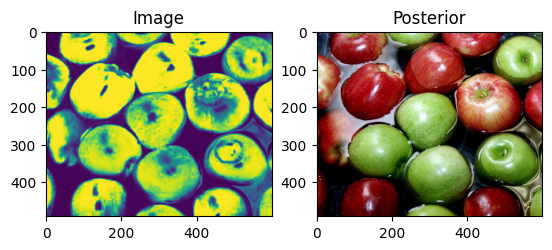

In [18]:
# use some other name (dont use p/p1/p2)
p = posterior('./apples/bobbing-for-apples.jpg', prior, mixGassEst_apples, mixGassEst_not_apples)


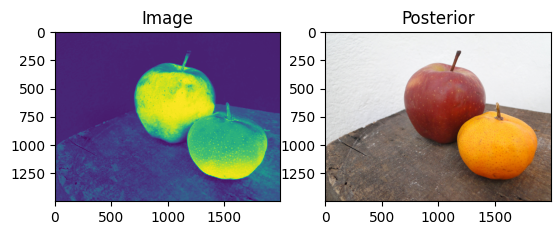

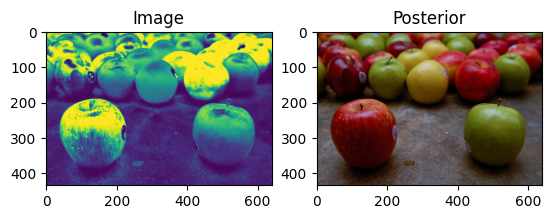

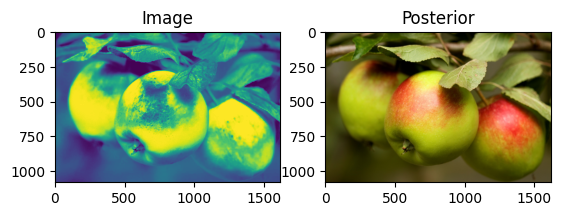

In [20]:
# I changed the order
# rename the variables
# rename the images
p2 = posterior('./testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg', prior, mixGassEst_apples, mixGassEst_not_apples)
p1 = posterior('./testApples/Apples_by_MSR_MikeRyan_flickr.jpg', prior, mixGassEst_apples, mixGassEst_not_apples)
p3 = posterior('./testApples/audioworm-QKUJj2wmxuI-original.jpg', prior, mixGassEst_apples, mixGassEst_not_apples)